In [1]:
import pandas as pd
import numpy as np
import re
from gensim.parsing.preprocessing import strip_multiple_whitespaces

import seaborn as sns
import matplotlib.pyplot as plt 

import os
os.chdir("..")

In [2]:
def read_lines(inputparsed):    
    """takes input from CoreNLP sentence parsed file and returns sentences"""
    #parse all lines from CoreNLP sentence split
    parsed = open(inputparsed, encoding = "utf-8")
    parsedfile = parsed.readlines()
    parsedlines = []

    #Only keep those lines which have Sentence #n in the line before
    for idx, text in enumerate(parsedfile):
        if text.startswith("Sentence #"):
            parsedlines.append(parsedfile[idx+1].replace('\n','').strip())
    
    return parsedlines

def gen_poss(line, verb_match, pre_dict):
    """generates all possibilities of patterns that a multi word line implies,
    by extracting partial patterns and resolving placeholder words"""
    poss = []

    #replace special tokens in text that are clear at this point
    line = line.replace("*", verb_match)
    line = line.replace("- ", "")
    line = line.replace("+","")
    line = line.replace("%","")
    line = line.replace("^","")
    line = line.replace("$","")

    #split line by possibility indicators and code (always ends possibility)
    #example.: "- $ * (P ON KILLING (P OF + [010] #  COMMENT <ELH 07 May 2008>"
    poss_split = re.split("\(P |\[.*]",line) 

    if len(poss_split) > 2: #2 is if no (P in the line
        #only combining the first (P, as they share the same code 
        #and the longer version will never be contained in a text if the shorter isnt
        poss.append(strip_multiple_whitespaces(" ".join(poss_split[:2])).lower().rstrip().lstrip())
    else: 
        poss.append(strip_multiple_whitespaces(poss_split[0].lower().rstrip().lstrip()))

    cleaned = []
    for text in list(set(poss)):
        c = 0
        for tag in list(pre_dict.keys()):
            if tag in text:
                for replacement in pre_dict[tag]:
                    cleaned.append(text.replace(tag, replacement))
                    c += 1
        if c == 0:
            cleaned.append(text)

    return cleaned
    

def verb_code_dict(pico_path, verb_path):
    """reads coding ontology and verb lists, 
    directly matches verbs to their CAMEO codes and returns this verbs:codes dictionairy.
    verb with codes that cannot be read are printed out as full line of the file"""
    #read PETRARCH Internal Coding Ontology (= pico)
    pico_path = os.path.join(os.getcwd(), pico_path)
    pico_file = open(pico_path, 'r')
    pico_lines = pico_file.readlines()

    #get all 20 codes with their respective code
    main_codes = {}                             #we run one iteration for all the main codes, only main codes contain relation name
    for line in pico_lines:
        line = line.split('#')
        if line[0] == "" or line[0] == "\n":    #only intro comments and empty lines
            continue
        else: 
            code_split = line[0].split(":")     #splits into CAMEO code and related hex
            if len(line) > 1 and code_split[0][2] == "0":      #only main categories have 0 in 3rd idx, [cat_num 0] -> [010]
                main_codes[code_split[0][:2]] = line[-1].replace("\n","")
    
    #map code to code we want to use in the training
    map_codes = {"DiplomaticCoop" : "Engage In Diplomatic Cooperation", 
                "MaterialCoop" : "Engage In Material Cooperation",
                "ProvideAid" : "Provide Aid",
                "Intend" : "Express Intend to Cooperate",
                "Exhibit Force Posture": "Exhibit Military Posture",
                "Use Unconventional Mass Violence" : "Engage In Unconventional Mass Violence"}
    main_codes = {k: (map_codes[v] if v in map_codes else v) for k, v in main_codes.items()}
    
    #read single word patterns and match their code to the relation extracted in main_codes
    verb_path = os.path.join(os.getcwd(), verb_path)
    verb_file = open(verb_path, 'r')
    verb_lines = verb_file.readlines()
    
    verb_dict = {}
    for line in verb_lines:
        if line[0] == "#":
            continue
        elif line.startswith("---"):    #main verbs have a lead code, which is applied to all very in the section
                                        #unless a separate code is specified for a specific verb in section
            try: cur_main_code = re.split("\[|\]|---", line)[2].replace(":","")[:2]  #we only need main codes which are first two numbers
                                                                                #sometimes code starts with ":", e.g.: ---  OFFEND   [:110]  ---
                                                                                #we just remove those to get the main code
            except:                     #depending on chosen verb dictionairy, there may be main verbs without lead codes
                print("couldn't finde code in: ", line.replace("\n","")) 
                cur_main_code == "--"
            if cur_main_code == "": cur_main_code = "--"
        elif line == "\n":              #skip empty lines
            continue
        elif line[0] == "-" or line[0] == "~" or line[0] == "+" or line[0] == "&": #removes all special structures we cannot use
            continue
        else:
            if len(re.split("\[|\]", line)) > 1:    #verbs with their own code, e.g.: AFFIRM [051] 
                code = re.split("\[|\]", line)[1].replace(":","")[:2]
                if code != "--":
                    if "{" in line:         #conjugated verbs, e.g. "APPLY {APPLYING APPLIED APPLIES } [020]"
                        line_s = re.split("\{|\}", line)    #split at { and }
                        verb_dict[line_s[0].lower().rstrip().lstrip()] = main_codes[code] 
                        for word in line_s[1].split():
                            verb_dict[word.lower().rstrip().lstrip()] = main_codes[code]
                    else:
                        word = re.split("\[|\]", line)[0]
                        verb_dict[word.lower().rstrip().lstrip()] = main_codes[code]
            else:
                if cur_main_code != "--":
                    if "{" in line:         #e.g. "HURRY {HURRIES HURRYING HURRIED }" 
                        line_s = re.split("\{|\}", line)    #split at { and }
                        verb_dict[line_s[0].lower().rstrip().lstrip()] = main_codes[cur_main_code]
                        for word in line_s[1].split():
                            verb_dict[word.lower().rstrip().lstrip()] = main_codes[cur_main_code]
                    else:                   #only single words with sometimes comments, e.g.: CENSURE  # JON 5/17/95
                        word = line.split("#")[0].rstrip()    #gets part before "#", removes all whitespaces to the right
                        verb_dict[word.lower().rstrip().lstrip()] = main_codes[cur_main_code]

    #read multi word patterns and create a dictionary for their code

    #get filler words that occur in multi word patterns
    verb_file = open(verb_path, 'r')
    verb_lines = verb_file.readlines()

    pre_dict = {}
    filter_list = []
    for line in verb_lines:
        if line.startswith("&"):
            cur_filter = line.rstrip()
        elif line.startswith("\n") and "cur_filter" in locals():
            pre_dict[cur_filter.lower()] = filter_list
            cur_filter = ""
            filter_list = []
        elif line.startswith("+") and cur_filter != "":
            filter_list.append(line.rstrip()[1:].replace("_", "").lower())
    del pre_dict[""]

    #generate dictionaries for multi word patterns
    verb_file = open(verb_path, 'r')
    verb_lines = verb_file.readlines()
    
    spec_dict = {}
    spec_code = {}

    count = 0
    for line in verb_lines:
        if line.startswith("- "):
            #get main verb as dict key
            try: 
                verb_match = re.search("# *\w+", line).group()
                verb_match = re.search("\w+", verb_match).group()
                verb_match = verb_match.replace("_", " ").lower()
            except: 
                count += 1

            #get code for line
            try:
                code = re.search("\[.*]", line).group()[1:3]
                if code != "--":
                    #get all possibility that the line indicates
                    poss = gen_poss(line, verb_match, pre_dict)
                    for pattern in poss:
                        spec_code[pattern] = main_codes[code]
                        if verb_match in spec_dict.keys():
                            spec_dict[verb_match].append(pattern)
                        else:
                            spec_dict[verb_match] = [pattern]
            except:
                count += 1

    print(f"{count} patterns could not be loaded")        

    return verb_dict, spec_dict, spec_code

In [3]:
df = pd.read_csv("data_src/unsupervised_data_preprocessed.csv", index_col = 0)
#the preprocessed data already removed inputs longer than 500 symbols and downsampled Consult & Make public statement
#see EDA_unsupervised.ipynb for more info

verb_dict, spec_dict, spec_code = verb_code_dict("soft_data/src/add_labels/dictionaries/PETR.Internal.Coding.Ontology.txt", "soft_data/src/add_labels/dictionaries/newdict.txt")

couldn't finde code in:  --- DEFEND  ###
couldn't finde code in:  --- REVOKE_   ###
couldn't finde code in:  --- SEND   ###
couldn't finde code in:  --- COLLAPSE  ###
22 patterns could not be loaded


In [4]:
import spacy
spacy.prefer_gpu(1) #maybe us en_core_web_lg instead of trf if no gpu
from spacy.symbols import nsubj, dobj, pobj, iobj, neg, xcomp, ccomp, VERB, AUX
nlp = spacy.load('en_core_web_trf')

/home/werner/thesis_valentin/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#extract the categorized relation
df["label"] = df.label.apply(lambda x: strip_multiple_whitespaces(x.replace("<triplet>"," <triplet> ")))
relation = []
for row in df.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <subj> | <triplet>)", rel_iter)
    relation.append(all_rels)
df["relations"] = relation 

Text(0.5, 0, 'Label')

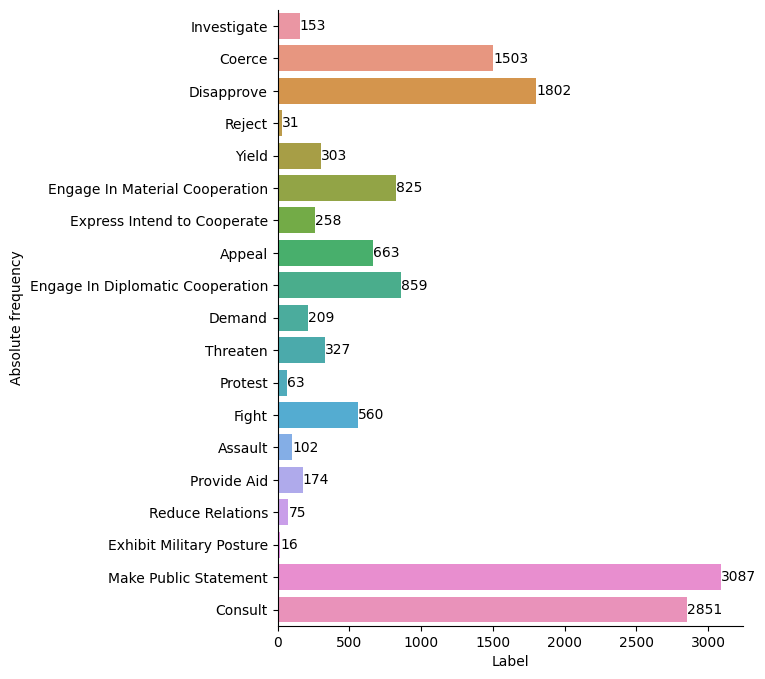

In [6]:
expl = df.explode("relations")
plt.figure(figsize=(6,8))
ax = sns.countplot(y = expl.relations)
ax.bar_label(ax.containers[0])
sns.despine()
plt.ylabel('Absolute frequency')
plt.xlabel('Label')

In [24]:
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [32]:
data = df.copy()

mlb = MultiLabelBinarizer()
accept_MLB = mlb.fit_transform(data["relations"])

cols = [f"rel{i}" for i in range(len(accept_MLB[0]))]
data = pd.concat([data, pd.DataFrame(accept_MLB, columns = cols)], axis=1)

#select indexes for train & val
splits = MultilabelStratifiedShuffleSplit(test_size=round(len(data.text) * 0.7), train_size= (len(data.text) - round(len(data.text) * 0.7)), random_state = 0)
val_idx, train_idx = next(splits.split(data.text, data[cols]))

train = data.iloc[train_idx][["text", "label", "relations"]]
pre_split = data.iloc[val_idx]

#select indexes test & val
splits = MultilabelStratifiedShuffleSplit(test_size=round(len(pre_split.text) * 0.5), train_size= (len(pre_split.text) - round(len(pre_split.text) * 0.5)), random_state = 0)
val_idx, test_idx = next(splits.split(pre_split.text, pre_split[cols]))

val = pre_split.iloc[val_idx][["text","label", "relations"]]
test = pre_split.iloc[test_idx][["text", "label", "relations"]]

print("train shape", train.shape)
print("val shape", val.shape)
print("test shape", test.shape)

train shape (8811, 3)
val shape (1887, 3)
test shape (1896, 3)


Text(0, 0.5, 'Label')

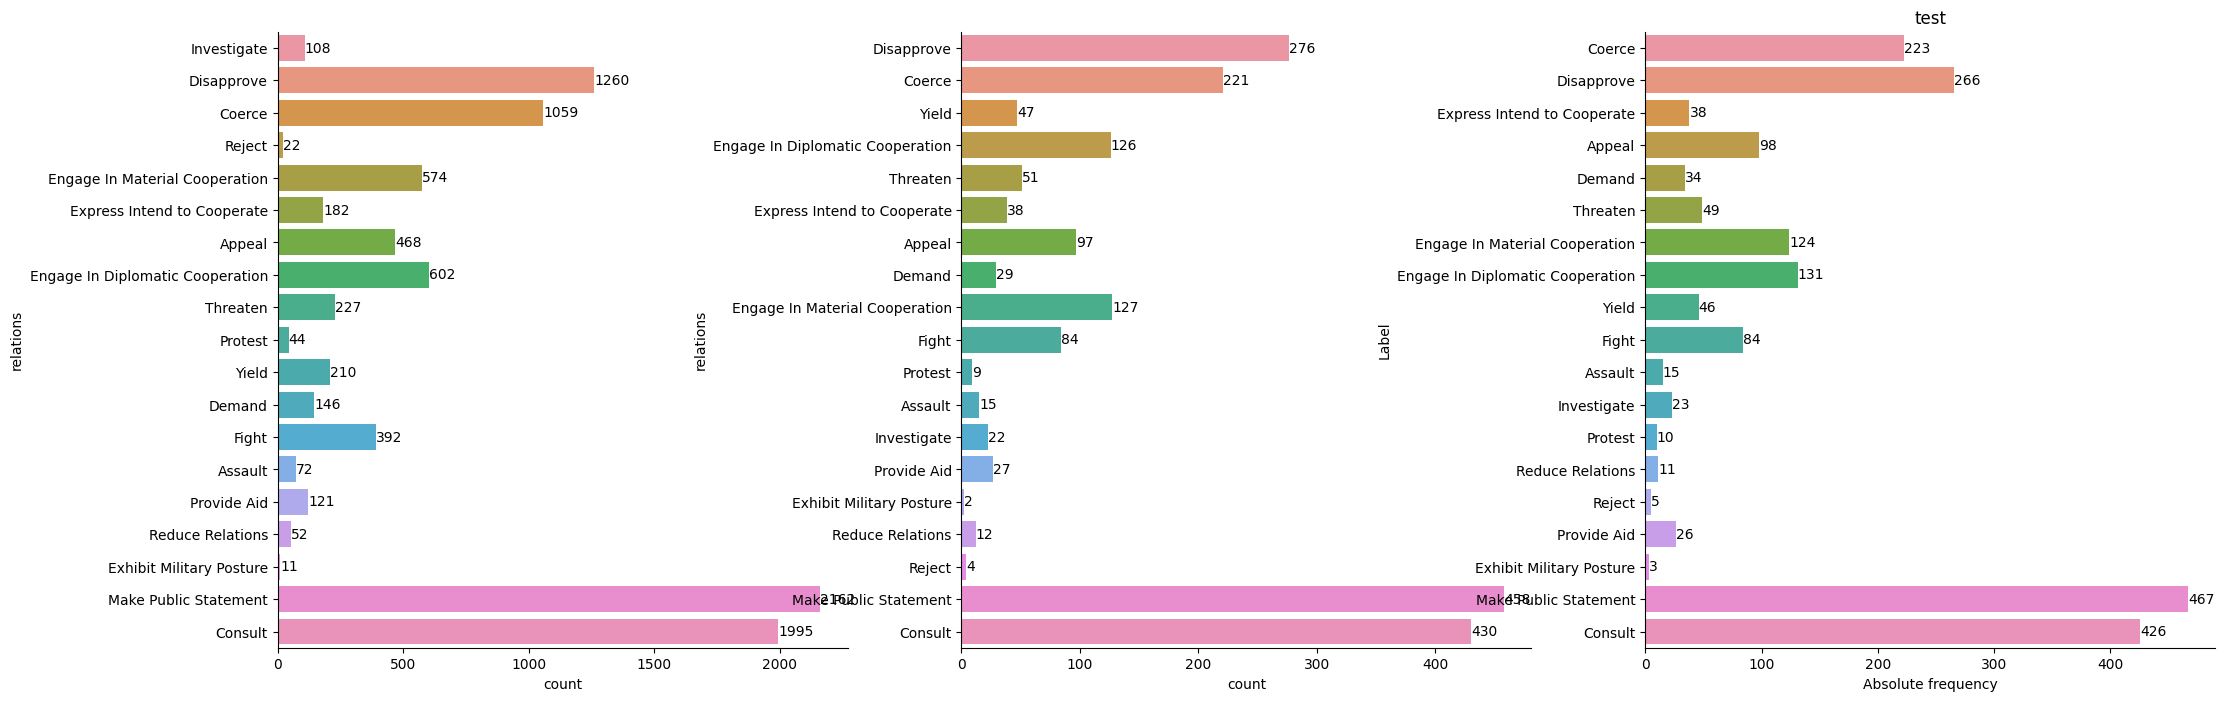

In [33]:
fig, ax = plt.subplots(1,3, figsize = (25,8))
expl2 = train.explode("relations")
#plt.figure(figsize=(6,8))
ax1 = sns.countplot(y = expl2.relations, ax = ax[0])
ax1.bar_label(ax1.containers[0])
sns.despine()
plt.title("train")
plt.xlabel('Absolute frequency')
plt.ylabel('Label')

expl3 = val.explode("relations")
#plt.figure(figsize=(6,8))
ax2 = sns.countplot(y = expl3.relations, ax = ax[1])
ax2.bar_label(ax2.containers[0])
sns.despine()
plt.title("val")
plt.xlabel('Absolute frequency')
plt.ylabel('Label')

expl4 = test.explode("relations")
#plt.figure(figsize=(6,8))
ax3 = sns.countplot(y = expl4.relations, ax = ax[2])
ax3.bar_label(ax3.containers[0])
sns.despine()
plt.title("test")
plt.xlabel('Absolute frequency')
plt.ylabel('Label')

In [34]:
train.head()

,text,label,relations
0,"On the way, a relative called BBC Gujarati's R...",<triplet> BBC Gujarati's Roxy Gadgekar <subj>...,[Investigate]
5,"(Danish Ismail/his Indian counterpart, Subrahm...",<triplet> his Indian counterpart <subj> China...,[Disapprove]
6,"But last month, China imposed an 80% tariff on...",<triplet> China <subj> Australian barley <obj...,[Coerce]
7,"This week, in a secretive process, China sente...",<triplet> China <subj> an Australian man <obj...,[Coerce]
8,"In a video that went viral this month, activis...",<triplet> activist Curtis Hayes Jr <subj> 16-...,[Coerce]


In [35]:
train[["text","label"]].to_csv("data_src/unsupervised/tr_unready.csv")
val[["text","label"]].to_csv("data_src/unsupervised/val.csv")
test[["text","label"]].to_csv("data_src/unsupervised/test.csv")

## Augmentation for evaluation split (70-15-15)

In [38]:
#categories to augment
train["inv"] = train.label.apply(lambda x: "Investigate" in x)
train["yield"] = train.label.apply(lambda x: "Yield" in x)
train["intend"] = train.label.apply(lambda x: "Express Intend to Cooperate" in x)
train["demand"] = train.label.apply(lambda x: "Demand" in x)
train["threat"] = train.label.apply(lambda x: "Threaten" in x)
train["protest"] = train.label.apply(lambda x: "Protest" in x)
train["assault"] = train.label.apply(lambda x: "Assault" in x)
train["aid"] = train.label.apply(lambda x: "Provide Aid" in x)
train["red"] = train.label.apply(lambda x: "Reduce Relations" in x)
train["rej"] = train.label.apply(lambda x: "Reject" in x)
train["post"] = train.label.apply(lambda x: "Exhibit Military Posture" in x)

#only mps / cons
data_inv = train[(train.inv == True)]
data_yield = train[(train["yield"] == True)]
data_intend = train[(train.intend == True)]
data_demand = train[(train.demand == True)]
data_threat = train[(train.threat == True)]
data_protest = train[(train.protest == True)]
data_assault = train[(train.assault == True)]
data_aid = train[(train.aid == True)]
data_red = train[(train.red == True)]
data_rej = train[(train.rej == True)]
data_post = train[(train.post == True)]

In [41]:
#Create entity dictionary for swaps
ent_dict = {"PERSON":[],"GPE":[],"NORP":[],"EVENTS":[],"FAC":[],"LAW":[],"ORG":[]}

for row in df.iterrows():

    subj = re.findall("(?<=<triplet> ).*?(?= <subj>)", row[1]["label"])
    obj = re.findall("(?<=<subj> ).*?(?= <obj>)", row[1]["label"])

    all_ents = subj + obj

    for sub in all_ents:
        ent_type = [word.ent_type_ for word in nlp(sub)]
        if "PERSON" in ent_type: ent_dict["PERSON"].append(sub)
        elif "GPE" in ent_type: ent_dict["GPE"].append(sub)
        elif "NORP" in ent_type: ent_dict["NORP"].append(sub)
        elif "EVENTS" in ent_type: ent_dict["EVENTS"].append(sub)
        elif "FAC" in ent_type: ent_dict["FAC"].append(sub)
        elif "LAW" in ent_type: ent_dict["LAW"].append(sub)
        elif "ORG" in ent_type: ent_dict["ORG"].append(sub)
    
    if row[0] % 500 == 0: print("done with ", row[0])

done with  0
done with  500
done with  1000
done with  1500
done with  2000
done with  2500
done with  3000
done with  3500
done with  4000
done with  4500
done with  5000
done with  5500
done with  6000
done with  6500
done with  7000
done with  7500
done with  8000
done with  8500
done with  9000
done with  9500
done with  10000
done with  10500
done with  11000
done with  11500
done with  12000
done with  12500


In [42]:
ent_dict_deduped = {"PERSON":[],"GPE":[],"NORP":[],"EVENTS":[],"FAC":[],"LAW":[],"ORG":[]}
for key in ent_dict.keys():
    print(f"{key} found {len(ent_dict[key])}, including duplicates; {len(list(set(ent_dict[key])))} without duplicates")
    ent_dict_deduped[key] = list(set(ent_dict[key]))

PERSON found 10682, including duplicates; 6711 without duplicates
GPE found 6942, including duplicates; 3207 without duplicates
NORP found 3557, including duplicates; 2529 without duplicates
EVENTS found 0, including duplicates; 0 without duplicates
FAC found 346, including duplicates; 205 without duplicates
LAW found 48, including duplicates; 43 without duplicates
ORG found 4186, including duplicates; 2504 without duplicates


In [43]:
#example
np.random.choice(ent_dict_deduped["ORG"])

"Facebook's digital currency"

In [45]:
def draw_new_ent(ent, taken_ents):
    ent_type = [word.ent_type_ for word in nlp(ent)]
    if "PERSON" in ent_type: 
        remainder = list(set(ent_dict_deduped["PERSON"]).difference(set(taken_ents)))
        new_ent = np.random.choice(ent_dict_deduped["PERSON"])
    elif "GPE" in ent_type: 
        remainder = list(set(ent_dict_deduped["GPE"]).difference(set(taken_ents)))
        new_ent = np.random.choice(ent_dict_deduped["GPE"])
    elif "NORP" in ent_type: 
        remainder = list(set(ent_dict_deduped["NORP"]).difference(set(taken_ents)))
        new_ent = np.random.choice(ent_dict_deduped["NORP"])
    elif "EVENTS" in ent_type:
        remainder = list(set(ent_dict_deduped["EVENTS"]).difference(set(taken_ents)))
        new_ent = np.random.choice(ent_dict_deduped["EVENTS"])
    elif "FAC" in ent_type: 
        remainder = list(set(ent_dict_deduped["FAC"]).difference(set(taken_ents)))
        new_ent = np.random.choice(ent_dict_deduped["FAC"])
    elif "LAW" in ent_type: 
        remainder = list(set(ent_dict_deduped["LAW"]).difference(set(taken_ents)))
        new_ent = np.random.choice(ent_dict_deduped["LAW"])
    elif "ORG" in ent_type: 
        remainder = list(set(ent_dict_deduped["ORG"]).difference(set(taken_ents)))
        new_ent = np.random.choice(ent_dict_deduped["ORG"])
    
    try: 
        if new_ent: return new_ent
    except: 
        #if no substitute can be found for one entity, the other entity can still be augmented
        return ent

aug_df = pd.DataFrame(columns = ["text","label"])

df_list = [data_inv, data_yield, data_intend, data_demand, data_threat, data_protest, data_assault, data_aid, data_red, data_rej, data_post] 

for sub_df in df_list:

    for i in range(min(16, int(500/sub_df.shape[0]))):

        new_sent = []
        
        for row in sub_df.iterrows():

            sent = row[1]["text"]
            label = row[1]["label"]

            subj = re.findall("(?<=<triplet> ).*?(?= <subj>)", row[1]["label"])
            obj = re.findall("(?<=<subj> ).*?(?= <obj>)", row[1]["label"])

            taken_ents = []
            for sub in subj:
                new_subj = draw_new_ent(sub, taken_ents)
                taken_ents.append(new_subj)
                sent = sent.replace(sub, new_subj)
                label = label.replace(sub, new_subj)
            
            for sub in obj:
                new_obj = draw_new_ent(sub, taken_ents)
                taken_ents.append(new_obj)
                sent = sent.replace(sub, new_obj)
                label = label.replace(sub, new_obj)
            
            new_sent.append([sent, label])
        
        aug_df = pd.concat([aug_df, pd.DataFrame(new_sent, columns = ["text","label"])])

In [46]:
aug_df

,text,label
0,"On the way, a relative called Joko Widodo and ...",<triplet> Joko Widodo <subj> Hollywood legend...
1,Africa Check fact-checked Cathy Giesell in Sep...,<triplet> Africa Check <subj> Cathy Giesell <...
2,the 46th US president have been investigating ...,<triplet> the 46th US president <subj> Taliba...
3,Attorney General William Barr provided no deta...,<triplet> UN's trade chief <subj> alleged vic...
4,RCMP union Director Chris Wray said last week ...,<triplet> RCMP union <subj> Libertarian lawma...
...,...,...
6,9:17am: Lithuania calls for more air defences ...,<triplet> a febrile House <subj> Russian fami...
7,Belarus has said Belarus will not enter the wa...,<triplet> Duduzane Duduzane Zuma <subj> Europ...
8,Belarus has said Belarus will not enter the wa...,<triplet> White House Press Secretary Jen Psa...
9,Belarus has said Belarus will not enter the wa...,<triplet> UN Secretary General António Guterr...


In [47]:
#extract the categorized relation
aug_df["label"] = aug_df.label.apply(lambda x: strip_multiple_whitespaces(x.replace("<triplet>"," <triplet> ")))
relation = []
for row in aug_df.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <subj> | <triplet>)", rel_iter)
    relation.append(all_rels)
aug_df["relations"] = relation 

In [48]:
aug_df[aug_df.duplicated(["text","label"])]

,text,label,relations
94,Varane will have gone a month without playing ...,<triplet> Les Bleus <subj> Les Bleus's openin...,[Express Intend to Cooperate]
14,ZEP holders have sought to challenge Cabinet's...,<triplet> ZEP holders <subj> ZEP holders <obj...,[Demand]
14,ZEP holders have sought to challenge Cabinet's...,<triplet> ZEP holders <subj> ZEP holders <obj...,[Demand]
156,"On Tuesday, The North warned The North would p...",<triplet> The North <subj> The North's joint ...,[Threaten]
44,WC church leaders to take part in silent prote...,<triplet> Western Cape church leaders <subj> ...,"[Protest, Consult]"
44,WC church leaders to take part in silent prote...,<triplet> Western Cape church leaders <subj> ...,"[Protest, Consult]"
100,"With a hollowed out newsroom, AdvertisingRead ...",<triplet> AdvertisingRead <subj> AdvertisingR...,[Provide Aid]
100,"With a hollowed out newsroom, AdvertisingRead ...",<triplet> AdvertisingRead <subj> AdvertisingR...,[Provide Aid]
100,"With a hollowed out newsroom, AdvertisingRead ...",<triplet> AdvertisingRead <subj> AdvertisingR...,[Provide Aid]
0,Jane Golding tables Jane Golding's budget vote...,<triplet> Jane Golding <subj> Jane Golding's ...,[Reject]


### verb augmentation

In [49]:
verb_dict_rev = {}
for key, value in verb_dict.items():
    verb_dict_rev.setdefault(value, []).append(key)

In [51]:
from transformers import pipeline
pipeline = pipeline('feature-extraction', model='bert-large-uncased', device = 1)

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from sklearn.metrics.pairwise import cosine_similarity

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
def extract_verb(list):
    verb_list = [sub[1] for sub in list]
    return verb_list

In [53]:
aug_df

,text,label,relations
0,"On the way, a relative called Joko Widodo and ...",<triplet> Joko Widodo <subj> Hollywood legend...,[Investigate]
1,Africa Check fact-checked Cathy Giesell in Sep...,<triplet> Africa Check <subj> Cathy Giesell <...,[Investigate]
2,the 46th US president have been investigating ...,<triplet> the 46th US president <subj> Taliba...,[Investigate]
3,Attorney General William Barr provided no deta...,<triplet> UN's trade chief <subj> alleged vic...,[Investigate]
4,RCMP union Director Chris Wray said last week ...,<triplet> RCMP union <subj> Libertarian lawma...,[Investigate]
...,...,...,...
6,9:17am: Lithuania calls for more air defences ...,<triplet> a febrile House <subj> Russian fami...,[Exhibit Military Posture]
7,Belarus has said Belarus will not enter the wa...,<triplet> Duduzane Duduzane Zuma <subj> Europ...,[Exhibit Military Posture]
8,Belarus has said Belarus will not enter the wa...,<triplet> White House Press Secretary Jen Psa...,[Exhibit Military Posture]
9,Belarus has said Belarus will not enter the wa...,<triplet> UN Secretary General António Guterr...,[Exhibit Military Posture]


In [54]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
#verb synonym swaps
doc = nlp(aug_df.text.iloc[1])

new_verb = []
for row in aug_df.iterrows():
    doc = nlp(row[1]["text"])
    for relation in row[1]["relations"]:
        for possible_verb in doc:
            if possible_verb.pos == VERB:
                if possible_verb.lemma_ in verb_dict_rev[relation]:
                    check = np.array(pipeline(possible_verb.lemma_))[0,1,:].reshape(1,-1)
                    best5 = [[0,""],[0,""],[0,""],[0,""],[0,""]]
                    for verb in verb_dict_rev[relation]:
                        lem = lemmatizer.lemmatize(verb,"v")
                        best5_lem = [lemmatizer.lemmatize(verb,"v") for verb in extract_verb(best5)]
                        if lem != possible_verb.lemma_ and lem not in best5_lem:
                            sim = cosine_similarity(check, np.array(pipeline(verb))[0,1,:].reshape(1,-1))
                            if sim > best5[0][0]:
                                best5[0] = [sim, verb]
                                best5 = sorted(best5, key= lambda x: x[0])
                            
                    new_verb.append([row[1]["text"].replace(possible_verb.text, np.random.choice(extract_verb(best5))), row[1]["label"]])

In [56]:
df_aug_v = pd.DataFrame(new_verb, columns = ["text","label"])
df_full = pd.concat([df, df_aug_v])

In [57]:
#extract the categorized relation
df_full["label"] = df_full.label.apply(lambda x: strip_multiple_whitespaces(x.replace("<triplet>"," <triplet> ")))
relation = []
for row in df_full.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <subj> | <triplet>)", rel_iter)
    relation.append(all_rels)
df_full["relations"] = relation 

Text(0.5, 0, 'Label')

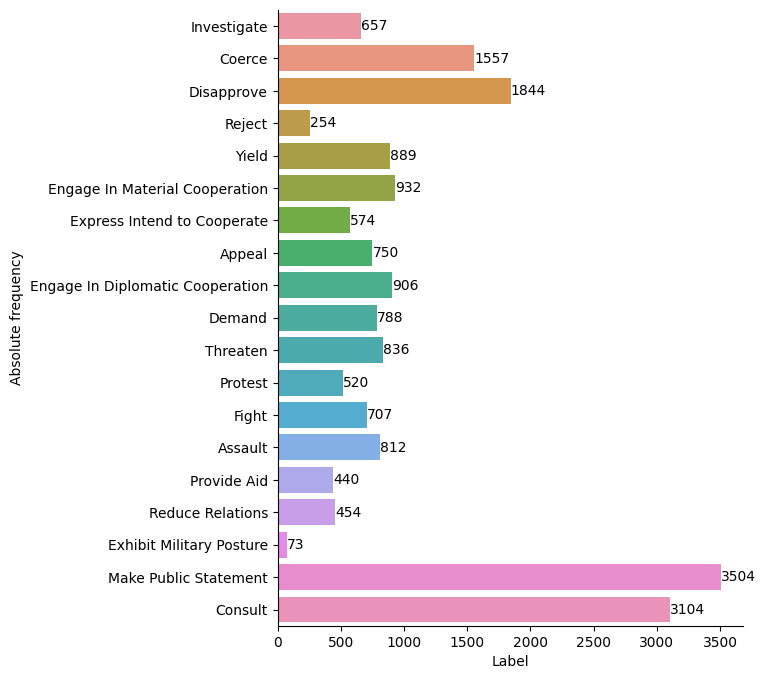

In [58]:
expl_3 = df_full.explode("relations")
plt.figure(figsize=(6,8))
ax = sns.countplot(y = expl_3.relations)
ax.bar_label(ax.containers[0])
sns.despine()
plt.ylabel('Absolute frequency')
plt.xlabel('Label')

In [59]:
df_full[["text","label"]].to_csv("data_src/unsupervised/eval_train.csv")

In [60]:
df_full

,text,label,relations
0,"On the way, a relative called BBC Gujarati's R...",<triplet> BBC Gujarati's Roxy Gadgekar <subj>...,[Investigate]
1,Where North Korean leader Kim Jong-un's sister...,<triplet> North Korean leader Kim Jong-un's s...,[Coerce]
2,India's has accused China of sending thousands...,<triplet> India <subj> China <obj> Disapprove,[Disapprove]
3,Three Boogaloo Bois members were charged with ...,<triplet> Nevada <subj> Three Boogaloo Bois m...,[Disapprove]
4,France sentences Equatorial Guinea VP</Text></...,<triplet> France <subj> Equatorial Guinea <ob...,[Coerce]
...,...,...,...
4092,FILE: Venezuela's president marshal near Two I...,<triplet> Venezuela's president <subj> Two It...,[Exhibit Military Posture]
4093,"""South Korea's's military detected Iranian Kur...",<triplet> Iranian Kurdish groups <subj> outgo...,[Exhibit Military Posture]
4094,Robert Mueller's'm parade more troops for A US...,<triplet> Robert Mueller's'm <subj> A US judg...,[Exhibit Military Posture]
4095,“KYIV's allies will marshal India's right. ”,<triplet> KYIV's allies <subj> India's right ...,[Exhibit Military Posture]


### For 70-15-15 split

In [61]:
#extract the categorized relation
df_full["label"] = df_full.label.apply(lambda x: strip_multiple_whitespaces(x.replace("<triplet>"," <triplet> ")))
relation = []
for row in df_full.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <subj> | <triplet>)", rel_iter)
    relation.append(all_rels)
df_full["relations"] = relation 

In [62]:
#remove these from test, train, val
idx = []
for row in df_full.iterrows():
    if "Engage In Unconventional Mass Violence" in row[1]["relations"]: idx.append(row[0])
    elif "Exhibit Military Posture" in row[1]["relations"]: idx.append(row[0])
    elif "Reject" in row[1]["relations"]: idx.append(row[0])
#Drop unconventional mass violence because not represented 
df_full = df_full.drop(index = idx).reset_index().drop(columns = ["index"])
df_full[["text","label"]].to_csv("data_src/unsupervised/train.csv")

In [68]:
val = pd.read_csv("data_src/unsupervised/val.csv", index_col = 0)
test = pd.read_csv("data_src/unsupervised/test.csv", index_col = 0)

In [64]:
#extract the categorized relation
val["label"] = val.label.apply(lambda x: strip_multiple_whitespaces(x.replace("<triplet>"," <triplet> ")))
relation = []
for row in val.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <subj> | <triplet>)", rel_iter)
    relation.append(all_rels)
val["relations"] = relation 

In [67]:
#remove these from test, train, val
idx = []
for row in val.iterrows():
    if "Engage In Unconventional Mass Violence" in row[1]["relations"]: idx.append(row[0])
    elif "Exhibit Military Posture" in row[1]["relations"]: idx.append(row[0])
    elif "Reject" in row[1]["relations"]: idx.append(row[0])
#Drop unconventional mass violence because not represented 
val = val.drop(index = idx).reset_index().drop(columns = ["index"])
val[["text","label"]].to_csv("data_src/unsupervised/val.csv")

In [71]:
#extract the categorized relation
test["label"] = test.label.apply(lambda x: strip_multiple_whitespaces(x.replace("<triplet>"," <triplet> ")))
relation = []
for row in test.iterrows():
    rel_iter = row[1]["label"] + " <triplet>"
    all_rels = re.findall("(?<=<obj> ).*?(?= <subj> | <triplet>)", rel_iter)
    relation.append(all_rels)
test["relations"] = relation 

In [72]:
idx = []
for row in test.iterrows():
    if "Engage In Unconventional Mass Violence" in row[1]["relations"]: idx.append(row[0])
    elif "Exhibit Military Posture" in row[1]["relations"]: idx.append(row[0])
    elif "Reject" in row[1]["relations"]: idx.append(row[0])
#Drop unconventional mass violence because not represented 
test = test.drop(index = idx).reset_index().drop(columns = ["index"])
test[["text","label"]].to_csv("data_src/unsupervised/test.csv")

Text(0, 0.5, 'Label')

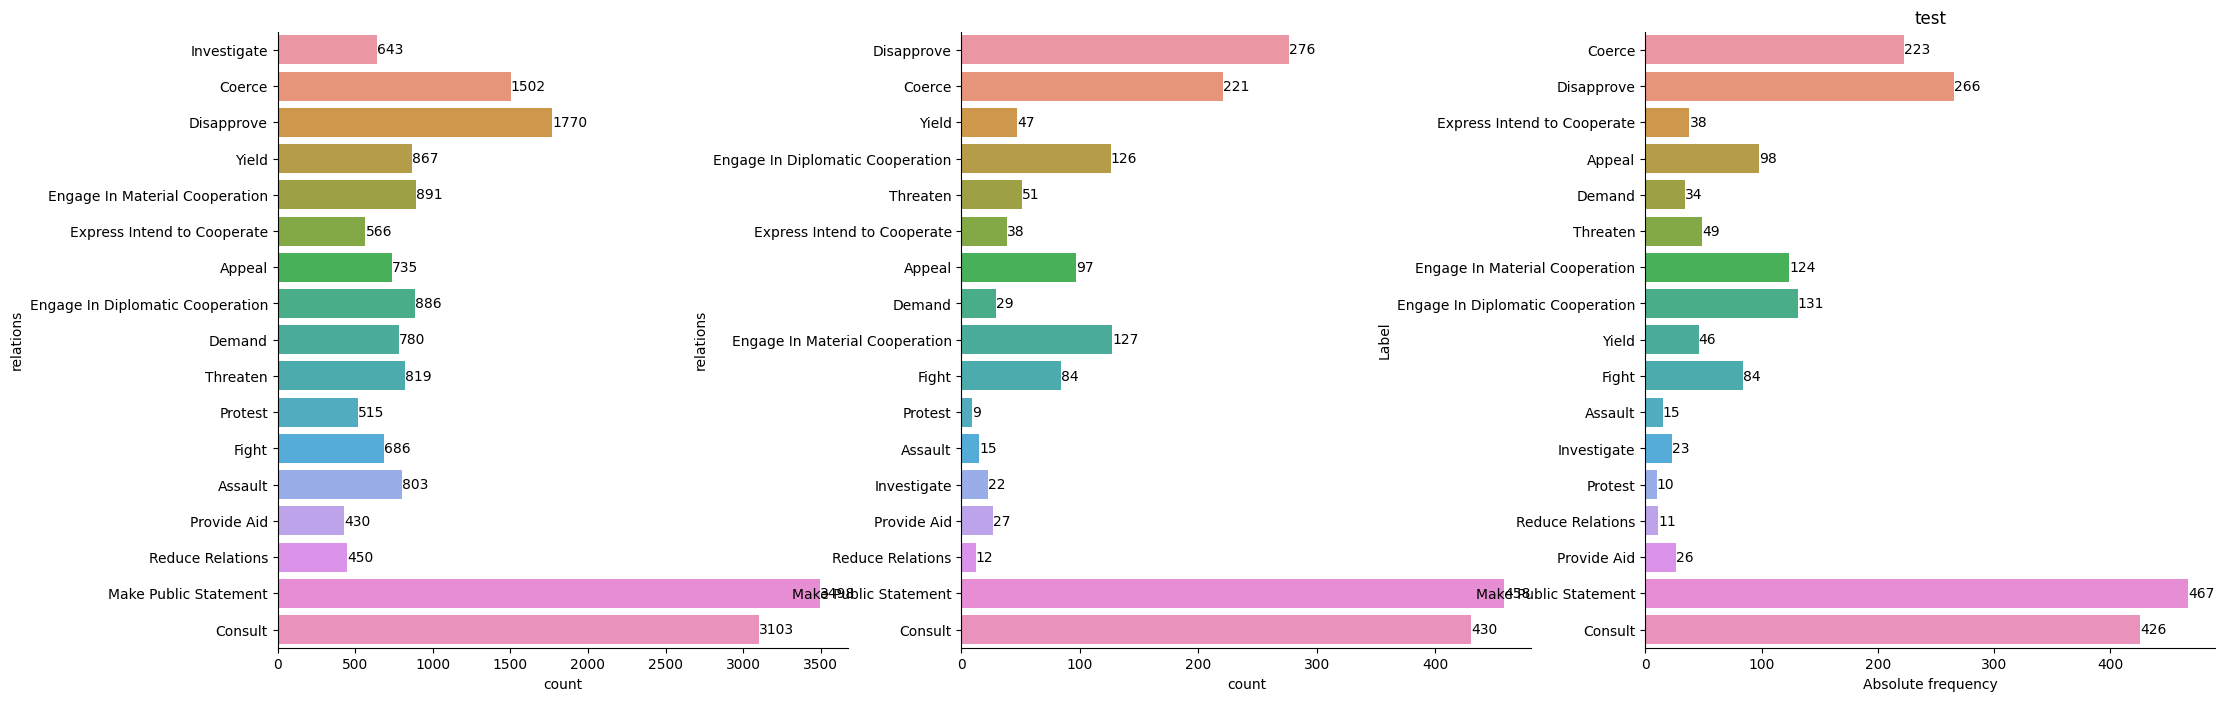

In [74]:
fig, ax = plt.subplots(1,3, figsize = (25,8))
expl2 = df_full.explode("relations")
#plt.figure(figsize=(6,8))
ax1 = sns.countplot(y = expl2.relations, ax = ax[0])
ax1.bar_label(ax1.containers[0])
sns.despine()
plt.title("train")
plt.xlabel('Absolute frequency')
plt.ylabel('Label')

expl3 = val.explode("relations")
#plt.figure(figsize=(6,8))
ax2 = sns.countplot(y = expl3.relations, ax = ax[1])
ax2.bar_label(ax2.containers[0])
sns.despine()
plt.title("val")
plt.xlabel('Absolute frequency')
plt.ylabel('Label')

expl4 = test.explode("relations")
#plt.figure(figsize=(6,8))
ax3 = sns.countplot(y = expl4.relations, ax = ax[2])
ax3.bar_label(ax3.containers[0])
sns.despine()
plt.title("test")
plt.xlabel('Absolute frequency')
plt.ylabel('Label')